In [1]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.spatial import distance
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score

from contrastive.evaluation.train_multiple_classifiers import compute_auc
from contrastive.utils.models_database import load_model_embs, load_model_preds, import_bdd

INFO: you cannot use deep_folding in brainvisa. Probably OK.


/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/contrastive/evaluation/train_multiple_classifiers.py:451: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='config_no_save', config_path="../configs")


In [2]:
# test model
test_model = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/file_fold_4_drop_rate=0.05_HCPfull/09-47-47"

# UMAP

In [22]:
def get_classifier_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[~aucs.index.isin(['label', 'median_pred', 'mean_pred'])]
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [23]:
# code taken from evaluation/clustering.py

def train_AP(data_df, n_clusters, return_method=False, verbose=False):
    af = AffinityPropagation(random_state=None).fit(data_df)
    cluster_labels_ini = af.labels_
    initial_centers = af.cluster_centers_indices_
    n_clusters_ = len(initial_centers)
    x_cluster_label = af.predict(data_df)

    if verbose:
        print("AP initial centers:", initial_centers)
        print("Initial number of clusters", n_clusters_)
    while n_clusters_ > n_clusters:
        af = AffinityPropagation(random_state=None).fit(data_df.iloc[af.cluster_centers_indices_,:])
        center_cluster_labels = af.labels_
        x_cluster_label = af.predict(data_df)
        n_clusters_ = len(af.cluster_centers_indices_)
        if verbose:
            print("Reduced number of clusters", n_clusters_)
    
    if return_method:
        return x_cluster_label, af
    else:
        return x_cluster_label

In [24]:
def clustering(df, clustering_method, n_clusters, return_method=False, verbose=False):
    if clustering_method == 'kmeans':
        clust_meth = KMeans(n_clusters=n_clusters)
        true_clusters = clust_meth.fit_predict(df)
    
    elif clustering_method == "AP":
        true_clusters, clust_meth = train_AP(df, n_clusters=n_clusters, return_method=True,
                                             verbose=verbose)
    
    else:
        raise ValueError("Unknown clustering method :(")
    
    if return_method:
        return true_clusters, clust_meth
    else:
        return true_clusters

In [25]:
def plot_svm_predictions(umap_embs, prediction_df, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75],
                         cmap = ['b', 'r'], verbose=False):
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_classifier_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            """if show_wrong_class:
                colors = []
                for i in range(prediction_df.shape[0]):
                    if prediction_df[la]"""

            plt.scatter(umap_embs[:,0], umap_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

In [26]:
def full_visualization(model_path, clustering_method="AP", n_clusters=5, quantiles=[0,0.5,1],
                       thresholds=[0.25,0.5,0.75], verbose=False):
    
    ## plot the svm curves
    plt.figure(figsize=(10, 7.5))
    fig = plt.imshow(mpimg.imread(model_path+"/cingulate_ACCpatterns_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    # give the model auc?


    ## compute the clusters on the embeddings
    # load the data
    data_df = load_model_embs(model_path)
    if verbose:
        print("Data df:")
        print(data_df[:5])

    true_clusters = clustering(data_df, clustering_method, n_clusters, verbose=verbose)


    ## apply umap
    reducer = umap.UMAP()
    umap_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(umap_embs.shape)
        print(umap_embs[:5])
    

    ## apply kmeans/AF on the UMAP data
    umap_clusters = clustering(pd.DataFrame(umap_embs), clustering_method, n_clusters, verbose=verbose)
    

    ## plot the umaps
    # plot the clusters
    plt.figure()
    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=true_clusters, alpha=0.6)
    plt.title(f"Clusters before umap (method={clustering_method})")
    plt.show()

    plt.figure()
    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=umap_clusters, alpha=0.6)
    plt.title(f"Clusters after umap (method={clustering_method})")
    plt.show()

    # load the predictions
    prediction_df = load_model_preds(model_path)
    if verbose:
        print("Prediction df:")
        print(prediction_df[:5])
    
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()

    # plot the svm predictions
    plot_svm_predictions(umap_embs, prediction_df, quantiles=quantiles, thresholds=thresholds,
                         cmap=cmap, verbose=verbose)
    

    ## generate the result df
    res_df = pd.DataFrame(umap_embs, index=data_df.index, columns=['umap0', 'umap1'])
    res_df['true_labels'] = prediction_df.label
    res_df['true_cluster'] = true_clusters
    res_df['umap_clusters'] = umap_clusters

    return res_df, reducer

/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


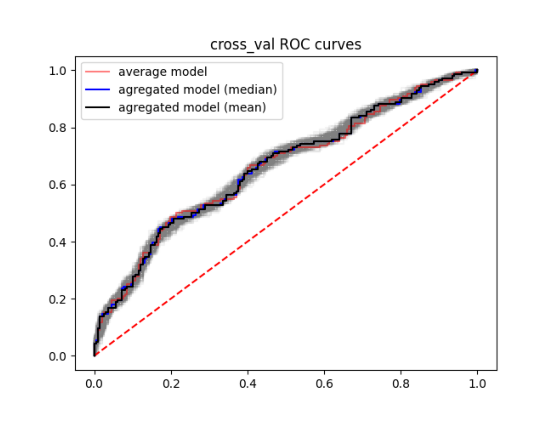

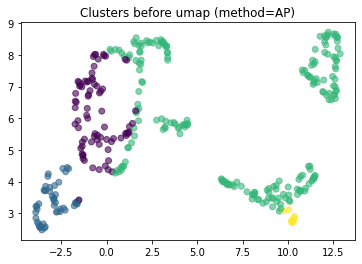

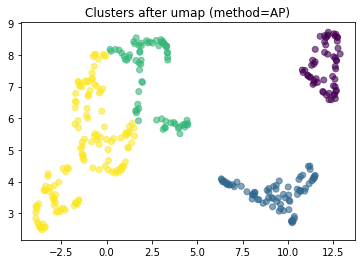

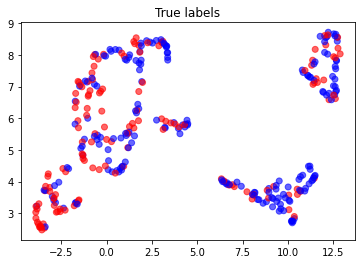

INFO:numexpr.utils: NumExpr defaulting to 4 threads.


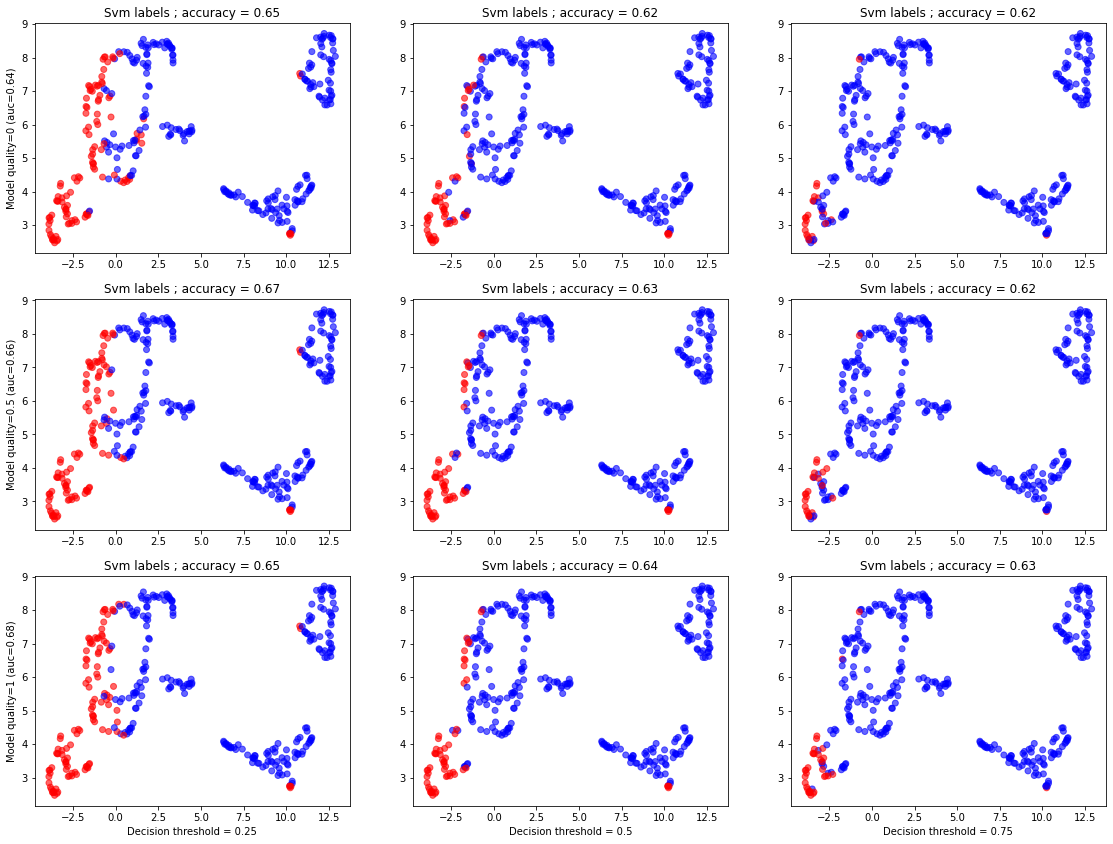

In [8]:
# test model
test_umap_embs, test_reducer = full_visualization(test_model, clustering_method='AP', n_clusters=4)

## Choose relevent SimCLR models

In [143]:
bdd = import_bdd()
bdd

model_path       auc   auc_std  \
100  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.752147  0.003479   
120  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.743639  0.004698   
119  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.729348  0.002100   
111  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.717813  0.013023   
150  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.694205  0.008692   
..                                                 ...       ...       ...   
39   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.482994  0.034076   
134  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.478818  0.022703   
19   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.473885  0.042166   
38   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.466274  0.034258   
163  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.463362  0.009882   

     accuracy  accuracy_std backbone_name  batch_size  drop_rate  \
100  0.705150      0.009098       convnet          16       0.05   
120  0.703261      0.006989       convnet          16       0.05   
119  0.669314      0.005821       convnet          16       0.05   
111  0.691284      0.013834       convnet          16       0.05   
150  0.669267      0.009264      pointnet          16       0.15   
..        ...           ...           ...         ...        ...   
39   0.512551      0.030729      densenet          16       0.15   
134  0.576880      0.003572      pointnet          16       0.05   
19   0.510393      0.050783       convnet          16       0.15   
38   0.547683      0.020623      densenet          16       0.15   
163  0.559331      0.002454      pointnet          16       0.05   

     early_stopping_patience  foldlabel  ... num_outputs  \
100                      100       True  ...           4   
120                      100       True  ...           4   
119                      100       True  ...           4   
111                      100       True  ...           4   
150                      100       True  ...          30   
..                       ...        ...  ...         ...   
39                       100      False  ...           4   
134                      100       True  ...           4   
19                       100      False  ...           4   
38                       100      False  ...           4   
163                      100      False  ...           4   

     num_representation_features  temperature  temperature_initial  \
100                            4          0.1                  0.1   
120                            4          0.1                  0.1   
119                            4          0.1                  0.1   
111                            4          0.1                  0.1   
150                           30          0.5                  0.5   
..                           ...          ...                  ...   
39                             4          0.1                  0.1   
134                            4          0.5                  0.5   
19                             4          0.1                  0.1   
38                             4          0.1                  0.1   
163                            4          0.1                  0.1   

     train_loss  val_loss  exclude  0.1_quantile          dataset_name  \
100    1.240257  1.669160    False      0.078811  cingulate_HCP_half_1   
120    1.251985  1.929024    False      0.594088  cingulate_HCP_half_1   
119    1.374010  1.463949    False      0.199899  cingulate_HCP_half_1   
111    1.954553  2.959328    False      0.652514  cingulate_HCP_half_1   
150    4.367986  4.052493    False     -0.430873  cingulate_HCP_half_1   
..          ...       ...      ...           ...                   ...   
39     3.753164  3.651408    False     -0.688383  cingulate_HCP_half_1   
134    5.256860  5.389712    False      0.129245  cingulate_HCP_half_1   
19     8.022524  6.433455    False      0.943119  cingulate_HC

In [139]:
pointnets = bdd[bdd.backbone_name == 'pointnet']

In [142]:
best_pointnet = pointnets.model_path.iloc[0]
print(best_pointnet)

worst_model = bdd.iloc[-1,:]
worst_model = worst_model.model_path
print(worst_model)

best_pointnet_df = load_model_embs(best_pointnet)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/fold_30_T=0.5
/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/no_4_drop_rate=0.05


In [13]:
densenets = bdd[bdd.backbone_name == 'densenet']
#mid_densenet = bdd.iloc[15,:]
#mid_densenet = mid_densenet.model_path
mid_densenet = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/2022-09-02/11-05-34"
print(mid_densenet)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/2022-09-02/11-05-34


/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:462: ConvergenceWarning: This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.
  "Labeling every sample as '-1'.", ConvergenceWarning)


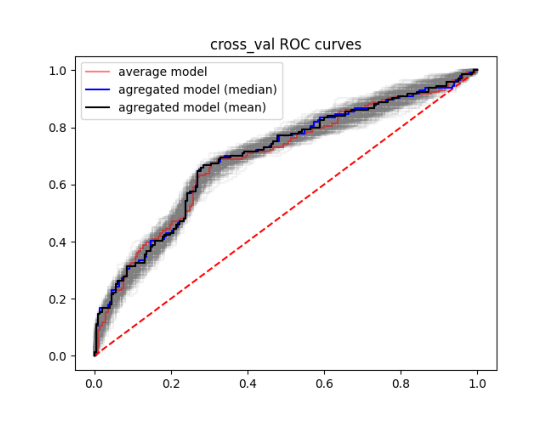

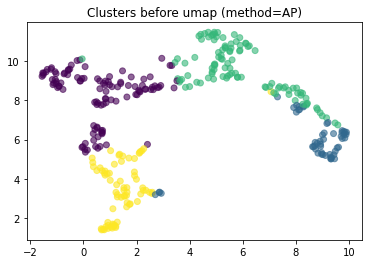

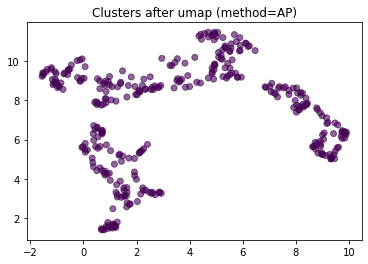

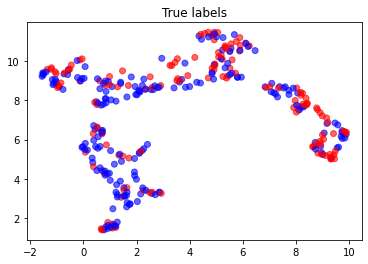

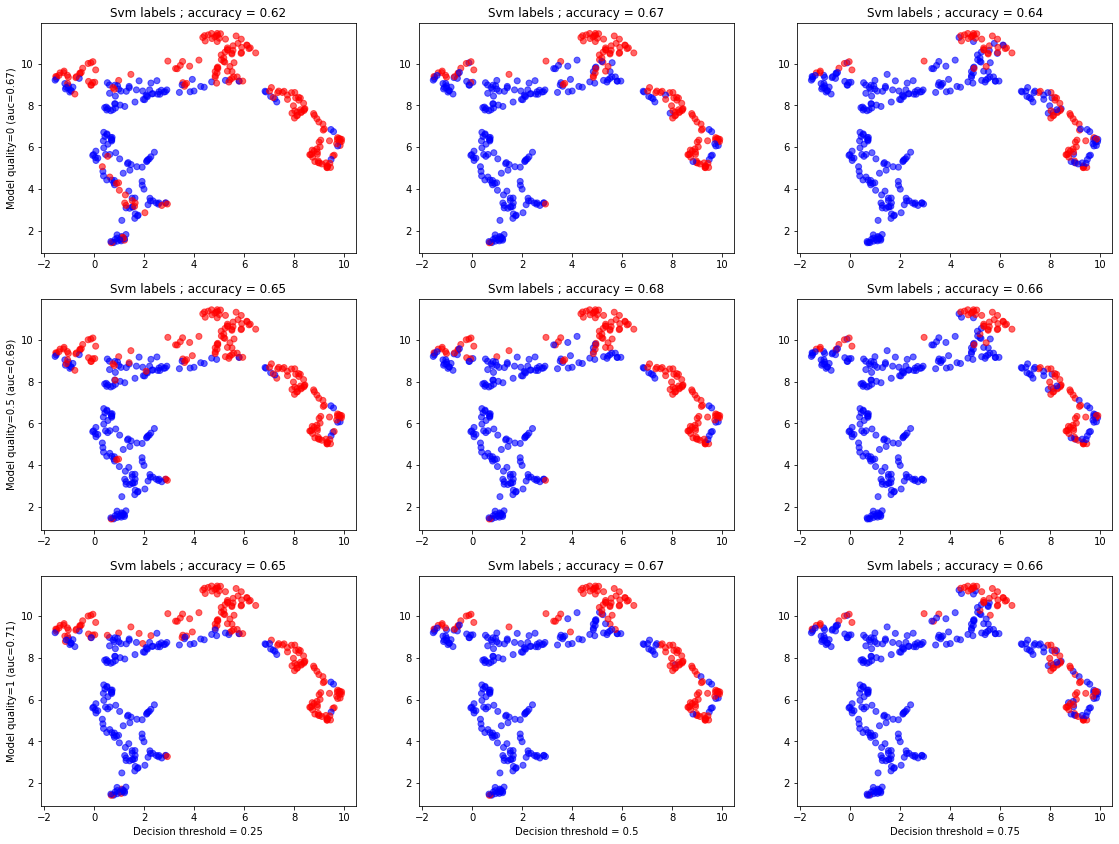

umap0      umap1  true_labels  \
ID                                                                       
1-03HUBJO_t0                          9.044611   6.014393            1   
1-08ANDTI_t0                          5.229183  10.078567            1   
1-11LEBJO_t0                          5.094050  10.192924            1   
1-15LEHMI_t0                          0.063167   9.704667            0   
1-17COLMA_t0                          1.996603   3.985816            0   
...                                        ...        ...          ...   
sub-inhibition25_ses-pretraining_T1w -1.201469   9.649148            1   
sub-inhibition26_ses-pretraining_T1w -1.406411   9.437798            0   
sub-inhibition28_ses-pretraining_T1w  1.620069   3.160548            0   
sub-inhibition29_ses-pretraining_T1w  0.843054   8.073358            0   
sub-inhibition31_ses-pretraining_T1w  1.643102   3.326134            0   

                                      true_cluster  umap_clusters  
ID                                                                 
1-03HUBJO_t0                                     1             -1  
1-08ANDTI_t0                                     2             -1  
1-11LEBJO_t0                                     2             -1  
1-15LEHMI_t0                                     0             -1  
1-17COLMA_t0                                     3             -1  
...                                            ...            ...  
sub-inhibition25_ses-pretraining_T1w             0             -1  
sub-inhibition26_ses-pretraining_T1w             0             -1  
sub-inhibition28_ses-pretraining_T1w             3             -1  
sub-inhibition29_ses-pretraining_T1w             0             -1  
sub-inhibition31_ses-pretraining_T1w             3             -1  

[341 rows x 5 columns]

In [28]:
best_pointnet_umap_embs, best_pointnet_reducer = full_visualization(best_pointnet, clustering_method='AP', n_clusters=6)
best_pointnet_umap_embs

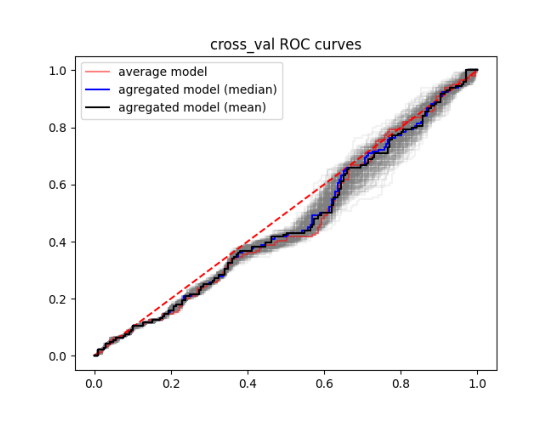

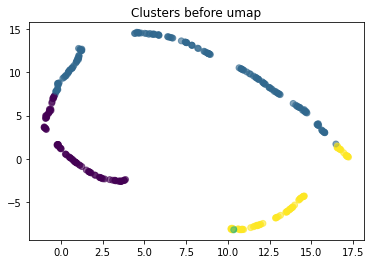

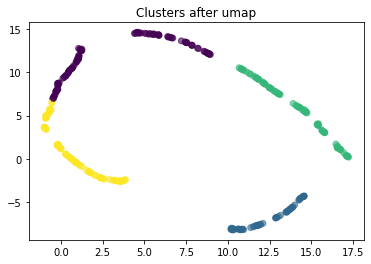

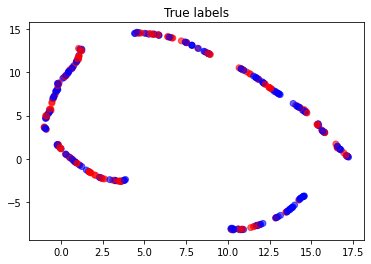

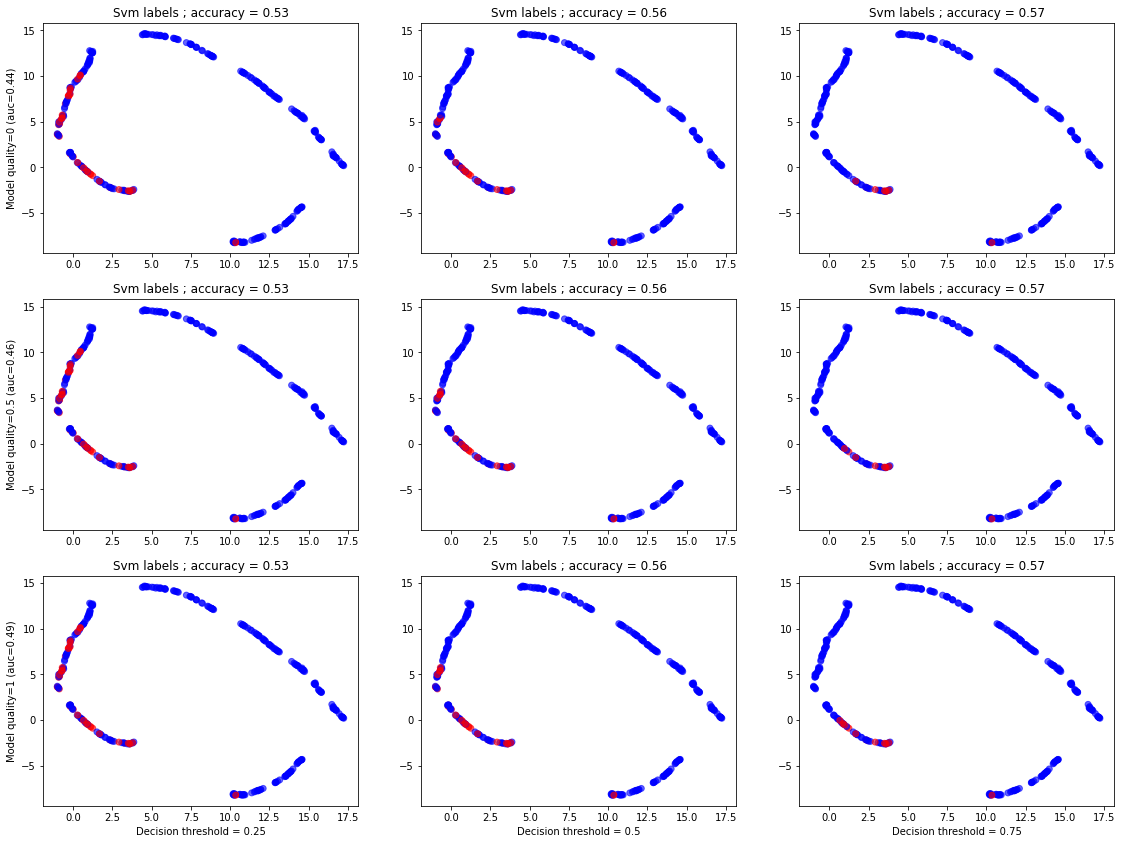

umap0      umap1  true_labels  \
ID                                                                        
1-03HUBJO_t0                           7.450698  13.527031            1   
1-08ANDTI_t0                          14.708471   5.457958            1   
1-11LEBJO_t0                          14.069140   6.215641            1   
1-15LEHMI_t0                          12.919815  -6.802500            0   
1-17COLMA_t0                          14.477120  -4.421797            0   
...                                         ...        ...          ...   
sub-inhibition25_ses-pretraining_T1w  10.889812  -8.143270            1   
sub-inhibition26_ses-pretraining_T1w  14.587399  -4.307145            0   
sub-inhibition28_ses-pretraining_T1w   3.795684  -2.482701            0   
sub-inhibition29_ses-pretraining_T1w  10.797002  10.424620            0   
sub-inhibition31_ses-pretraining_T1w  10.356461  -8.223945            0   

                                      true_cluster  umap_clusters  
ID                                                                 
1-03HUBJO_t0                                     1              0  
1-08ANDTI_t0                                     1              2  
1-11LEBJO_t0                                     1              2  
1-15LEHMI_t0                                     3              1  
1-17COLMA_t0                                     3              1  
...                                            ...            ...  
sub-inhibition25_ses-pretraining_T1w             3              1  
sub-inhibition26_ses-pretraining_T1w             3              1  
sub-inhibition28_ses-pretraining_T1w             0              3  
sub-inhibition29_ses-pretraining_T1w             1              2  
sub-inhibition31_ses-pretraining_T1w             2              1  

[341 rows x 5 columns]

In [52]:
full_visualization(worst_model)

### Select other interesting models

High variance models

In [42]:
filtered_bdd = bdd[bdd.auc_std >= 0.05]
filtered_bdd

model_path       auc   auc_std  \
75  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.693590  0.051831   
76  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.670914  0.051652   
24  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.668507  0.053301   
78  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.668161  0.050466   
22  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.627084  0.052677   
47  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.626335  0.050238   
72  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.593398  0.056054   
5   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.581583  0.057815   
43  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.574575  0.063551   
27  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.547569  0.057362   
29  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.519898  0.052222   

    accuracy  accuracy_std backbone_name  batch_size  drop_rate  \
75  0.619449      0.052646      densenet          16       0.05   
76  0.596364      0.056285      densenet          16       0.05   
24  0.601525      0.057313      densenet          16       0.15   
78  0.598956      0.053273      densenet          16       0.05   
22  0.577161      0.053945      densenet          16       0.15   
47  0.598792      0.041902       convnet          16       0.15   
72  0.585232      0.040975       convnet          16       0.05   
5   0.562100      0.052206       convnet          16       0.15   
43  0.555718      0.051553       convnet          16       0.15   
27  0.539683      0.044184      densenet          16       0.15   
29  0.517889      0.044333      densenet          16       0.15   

    early_stopping_patience  foldlabel  ... num_outputs  \
75                      100       True  ...          30   
76                      100       True  ...          30   
24                      100       True  ...          30   
78                      100       True  ...          30   
22                      100       True  ...          30   
47                      100      False  ...          30   
72                      100       True  ...          30   
5                       100       True  ...           4   
43                      100       True  ...           4   
27                      100       True  ...           4   
29                      100       True  ...           4   

    num_representation_features  temperature  temperature_initial  train_loss  \
75                           30         0.10                  0.1    0.762840   
76                           30         0.10                  0.1    1.159750   
24                           30         0.10                  0.1    0.728199   
78                           30         0.10                  0.1    1.041767   
22                           30         0.10                  0.1    1.329955   
47                           30         0.01                  0.1    0.172071   
72                           30         0.50                  0.5    3.714237   
5                             4         0.10                  0.1    4.480739   
43                            4         0.10                  0.1    4.664048   
27                            4         0.10                  0.1    4.531240   
29                            4         0.10                  0.1    4.442244   

    val_loss  exclude  0.1_quantile          dataset_name      git_branch  
75  1.369004    False      0.757828  cingulate_HCP_half_1  Run_03_aymeric  
76  2.443445    False      0.812578  cingulate_HCP_half_1  Run_03_aymeric  
24  1.858723    False      0.753235  cingulate_HCP_half_1  Run_03_aymeric  
78  1.704926    False      0.781419  cingulate_HCP_half_1  Run_03_aymeric  
22  3.381569    False      0.642852  cingulate_HCP_half_1  Run_03_aymeric  
47  0.144276    False     -0.318485  cingulate_HCP_half_1  Run_03_aymeric  
72  3.622833    False     -0.285862  cingulate_HCP_half_1  Run_03_aymeric  
5   2.831487    False  

In [43]:
best_densenet = filtered_bdd.iloc[0,:].model_path
high_variance_bad = filtered_bdd.iloc[-1,:].model_path

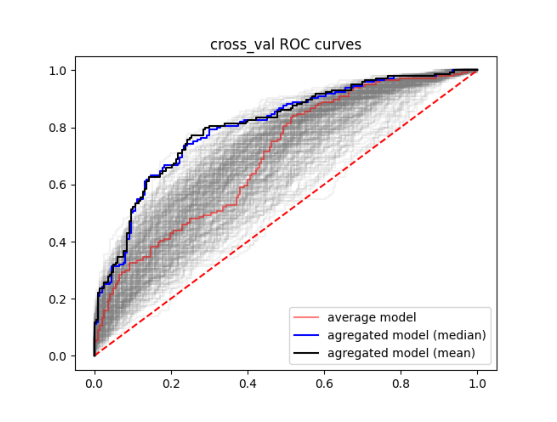

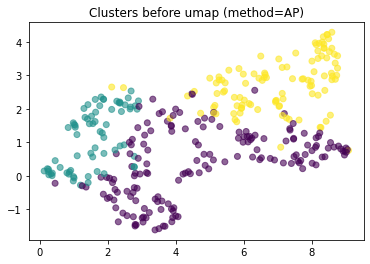

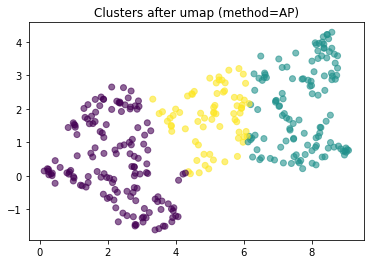

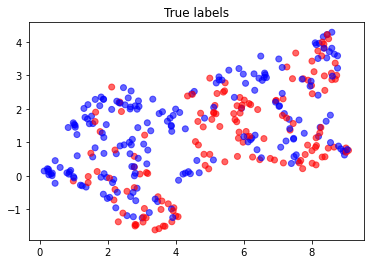

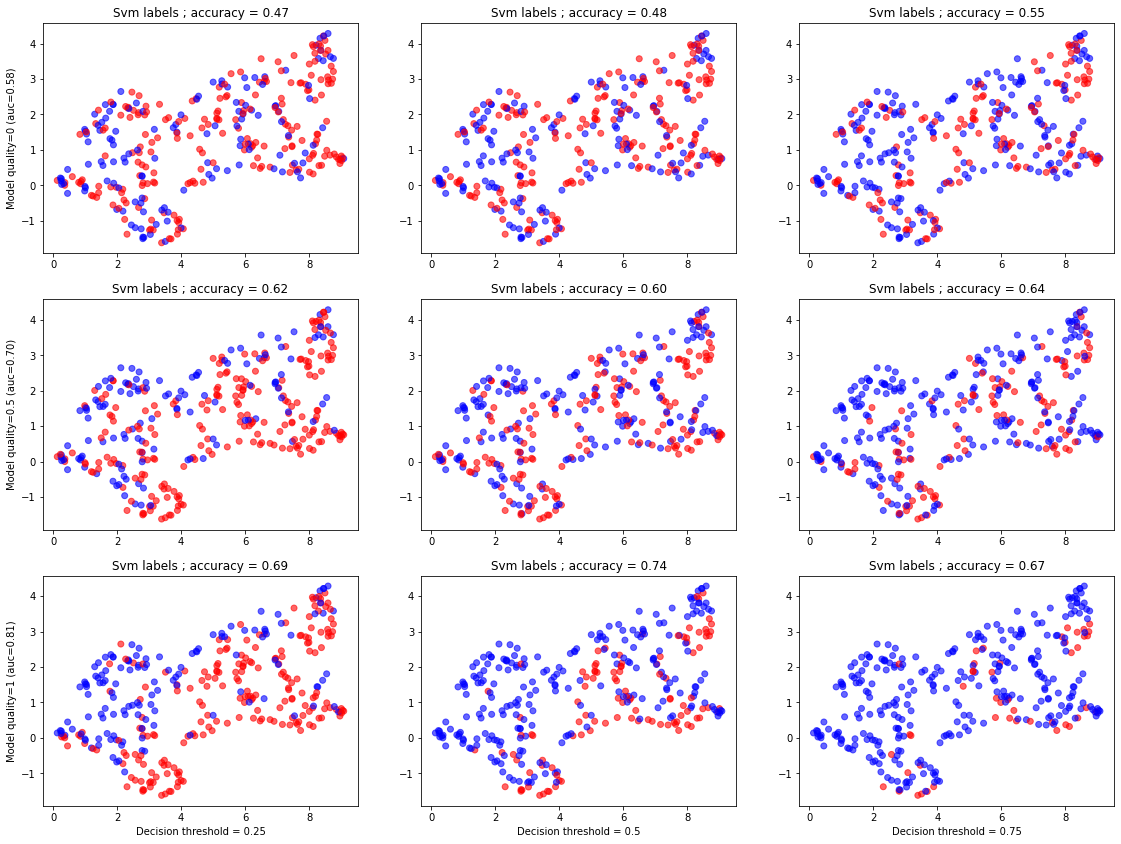

umap0     umap1  true_labels  \
ID                                                                      
1-03HUBJO_t0                          3.682964 -1.512191            1   
1-08ANDTI_t0                          2.779352  0.578125            1   
1-11LEBJO_t0                          3.137721  0.093079            1   
1-15LEHMI_t0                          3.465532 -0.773952            0   
1-17COLMA_t0                          4.212284  0.046784            0   
...                                        ...       ...          ...   
sub-inhibition25_ses-pretraining_T1w  8.694234  2.880546            1   
sub-inhibition26_ses-pretraining_T1w  8.606520  2.973087            0   
sub-inhibition28_ses-pretraining_T1w  3.881560  1.325465            0   
sub-inhibition29_ses-pretraining_T1w  6.936034  2.196704            0   
sub-inhibition31_ses-pretraining_T1w  5.858372  3.201226            0   

                                      true_cluster  umap_clusters  
ID                                                                 
1-03HUBJO_t0                                     0              0  
1-08ANDTI_t0                                     1              0  
1-11LEBJO_t0                                     0              0  
1-15LEHMI_t0                                     0              0  
1-17COLMA_t0                                     0              0  
...                                            ...            ...  
sub-inhibition25_ses-pretraining_T1w             2              1  
sub-inhibition26_ses-pretraining_T1w             2              1  
sub-inhibition28_ses-pretraining_T1w             0              2  
sub-inhibition29_ses-pretraining_T1w             2              1  
sub-inhibition31_ses-pretraining_T1w             2              2  

[341 rows x 5 columns]

In [45]:
best_densenet_umap_embs, best_densenet_reducer = full_visualization(best_densenet, clustering_method='AP', n_clusters=5)
best_densenet_umap_embs

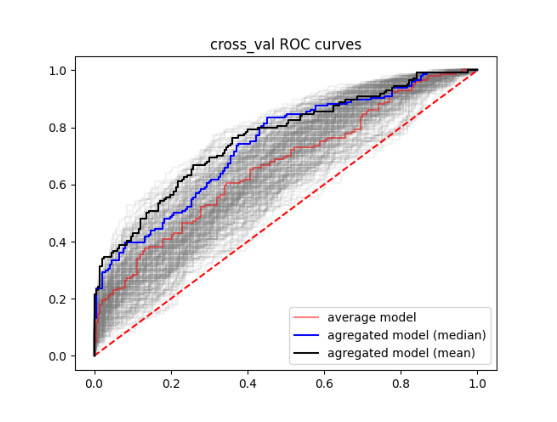

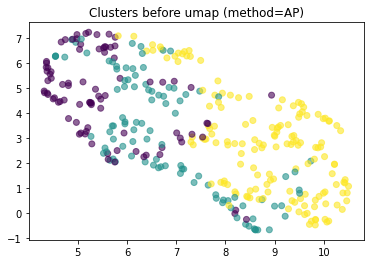

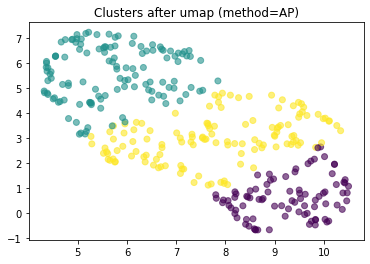

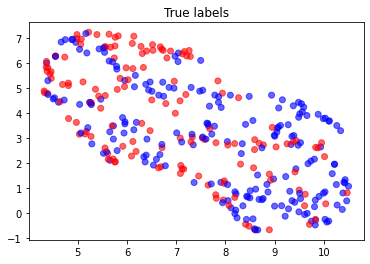

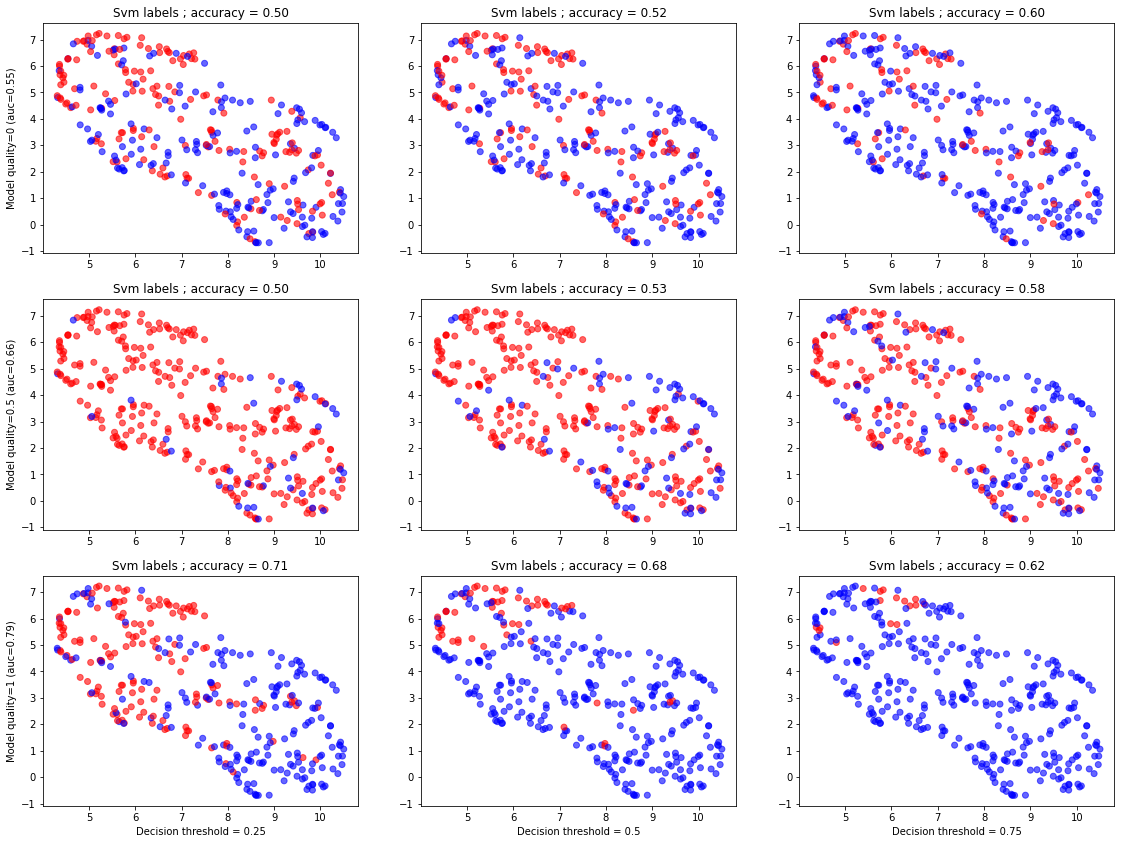

umap0     umap1  true_labels  \
ID                                                                       
1-03HUBJO_t0                           4.690942  5.138787            1   
1-08ANDTI_t0                           9.499567  0.911197            1   
1-11LEBJO_t0                           7.153035  1.749475            1   
1-15LEHMI_t0                           6.538734  1.907230            0   
1-17COLMA_t0                           6.405794  2.949699            0   
...                                         ...       ...          ...   
sub-inhibition25_ses-pretraining_T1w   4.549663  6.277579            1   
sub-inhibition26_ses-pretraining_T1w   4.544895  6.257310            0   
sub-inhibition28_ses-pretraining_T1w   9.590910  4.228182            0   
sub-inhibition29_ses-pretraining_T1w  10.216506  1.947420            0   
sub-inhibition31_ses-pretraining_T1w   5.433620  6.557940            0   

                                      true_cluster  umap_clusters  
ID                                                                 
1-03HUBJO_t0                                     0              1  
1-08ANDTI_t0                                     1              0  
1-11LEBJO_t0                                     1              2  
1-15LEHMI_t0                                     1              2  
1-17COLMA_t0                                     1              2  
...                                            ...            ...  
sub-inhibition25_ses-pretraining_T1w             1              1  
sub-inhibition26_ses-pretraining_T1w             1              1  
sub-inhibition28_ses-pretraining_T1w             2              2  
sub-inhibition29_ses-pretraining_T1w             2              0  
sub-inhibition31_ses-pretraining_T1w             0              1  

[341 rows x 5 columns]

In [391]:
full_visualization(mid_densenet, clustering_method='AP', n_clusters=5)

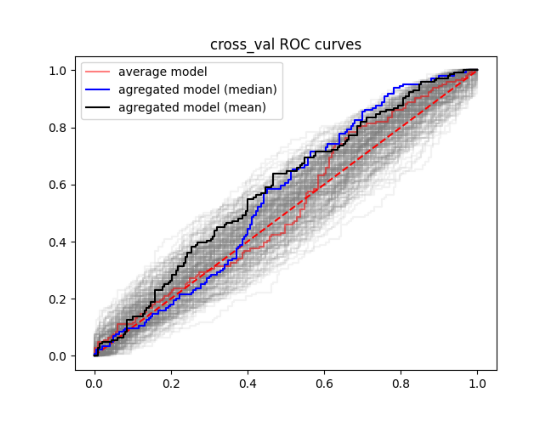

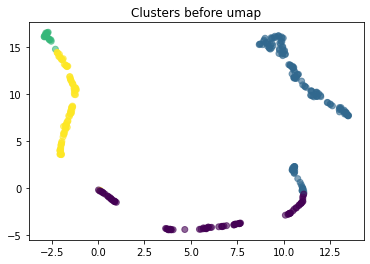

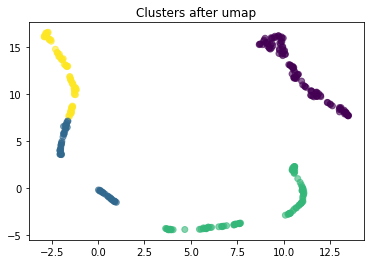

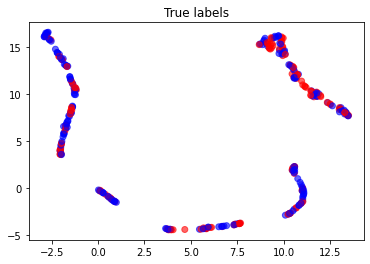

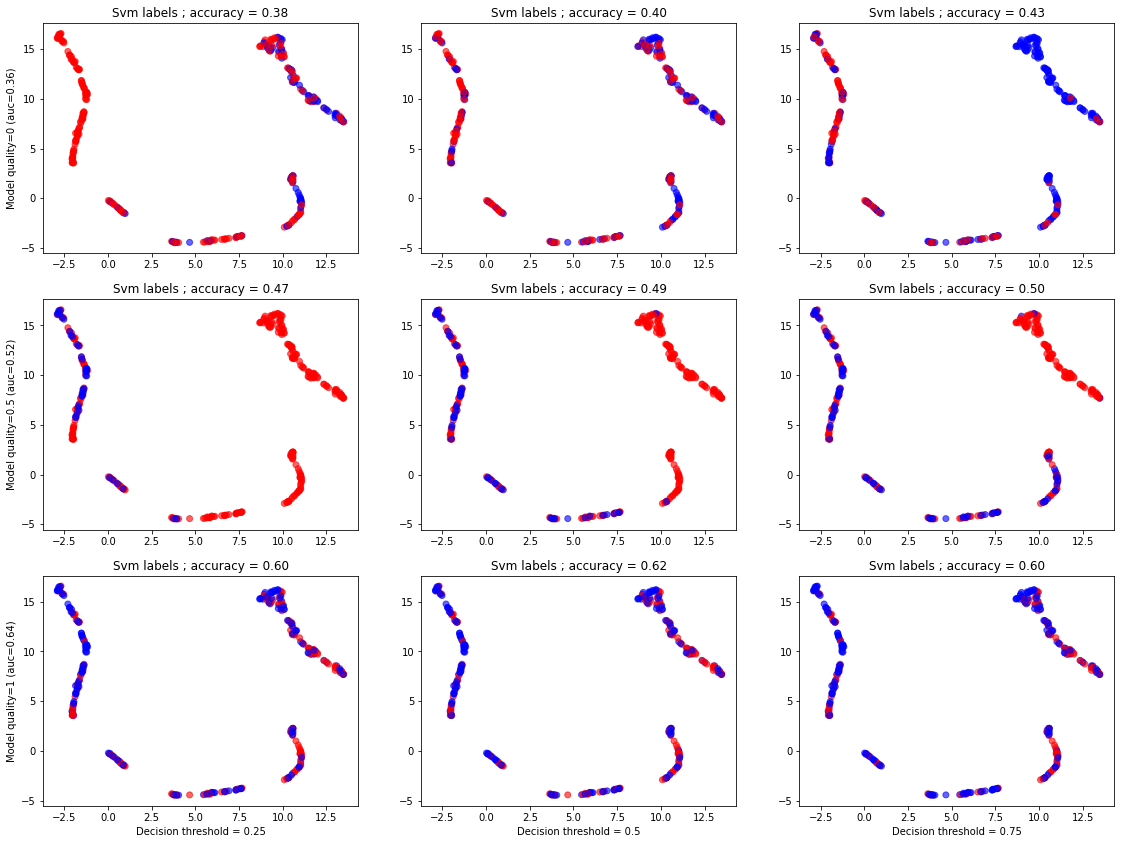

umap0      umap1  true_labels  \
ID                                                                        
1-03HUBJO_t0                          12.524666   8.864223            1   
1-08ANDTI_t0                          -2.003490   3.735979            1   
1-11LEBJO_t0                          10.474080   2.098395            1   
1-15LEHMI_t0                           0.893644  -1.404156            0   
1-17COLMA_t0                           5.461426  -4.413051            0   
...                                         ...        ...          ...   
sub-inhibition25_ses-pretraining_T1w   9.321561  15.992281            1   
sub-inhibition26_ses-pretraining_T1w   9.585983  16.038668            0   
sub-inhibition28_ses-pretraining_T1w   5.931217  -4.177302            0   
sub-inhibition29_ses-pretraining_T1w   0.542214  -0.910064            0   
sub-inhibition31_ses-pretraining_T1w  10.565081  11.772647            0   

                                      true_cluster  umap_clusters  
ID                                                                 
1-03HUBJO_t0                                     1              0  
1-08ANDTI_t0                                     3              1  
1-11LEBJO_t0                                     1              2  
1-15LEHMI_t0                                     0              1  
1-17COLMA_t0                                     0              2  
...                                            ...            ...  
sub-inhibition25_ses-pretraining_T1w             1              0  
sub-inhibition26_ses-pretraining_T1w             1              0  
sub-inhibition28_ses-pretraining_T1w             0              2  
sub-inhibition29_ses-pretraining_T1w             0              1  
sub-inhibition31_ses-pretraining_T1w             1              0  

[341 rows x 5 columns]

In [55]:
full_visualization(high_variance_bad)

### Convnets

In [145]:
convnets = bdd[bdd.backbone_name == 'convnet']

best_convnet = convnets.iloc[0,:].model_path
print(best_convnet)

n_conv = convnets.shape[0]
mid_convnet = convnets.iloc[n_conv//2,:].model_path
print(n_conv)
print(mid_convnet)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/2022-09-30/17-27-31
44
/neurospin/dico/agaudin/Runs/03_monkeys/Output/convnet_exploration/batch_size_4


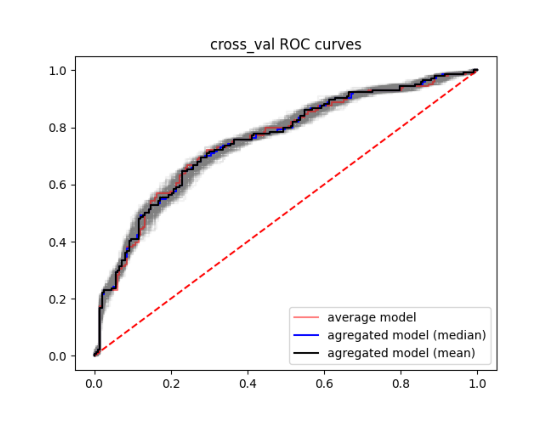

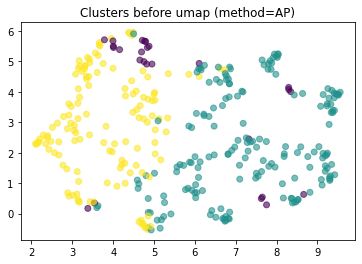

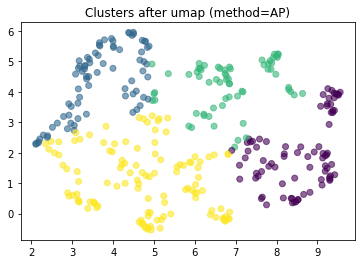

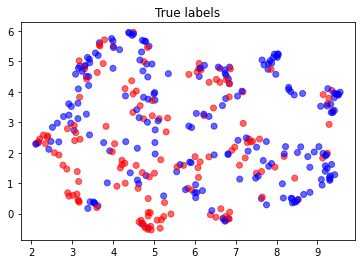

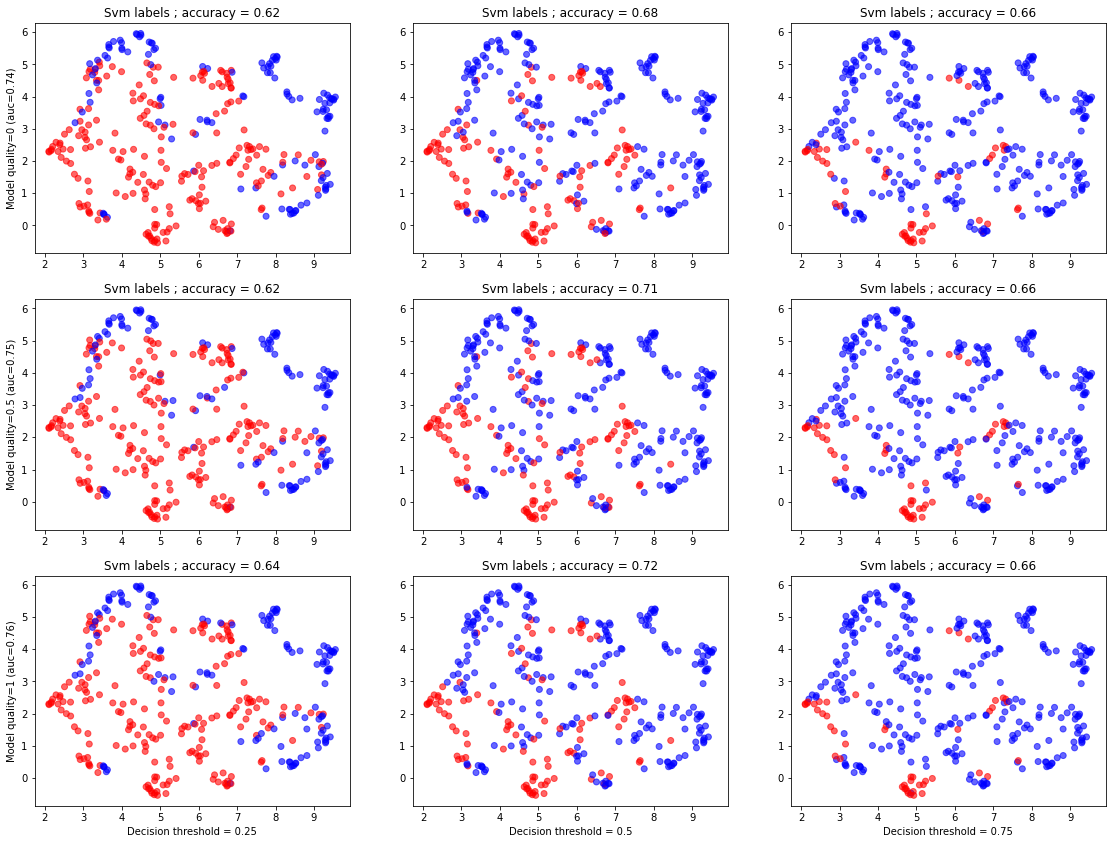

In [146]:
best_convnet_umap_embs, best_convnet_reducer = full_visualization(best_convnet)

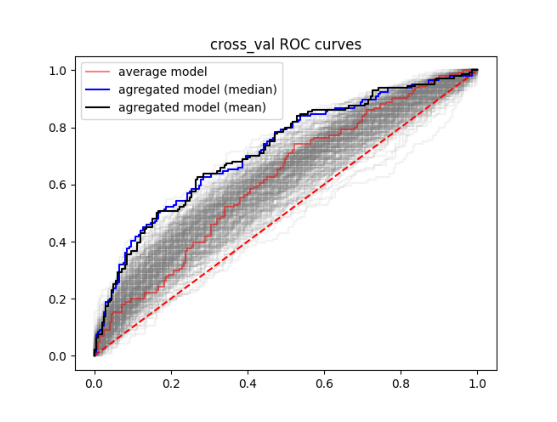

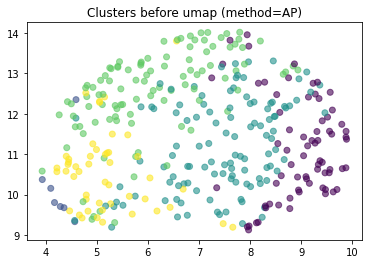

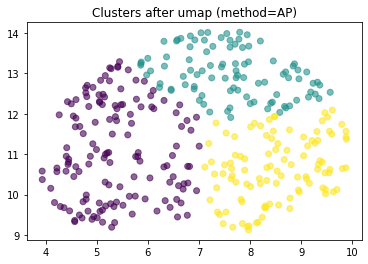

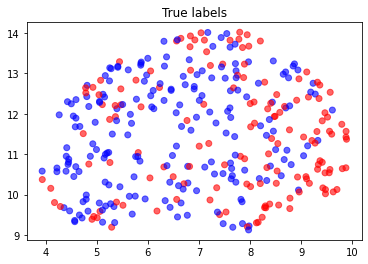

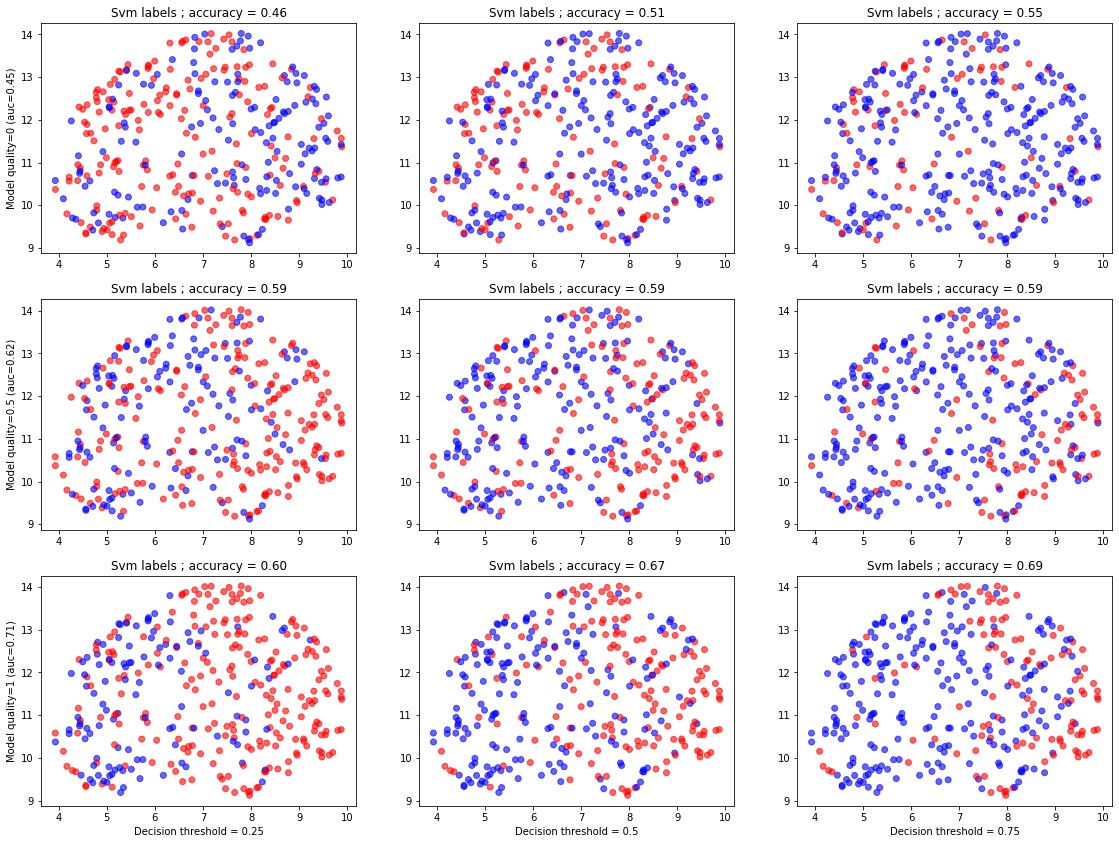

In [18]:
mid_convnet_umap_embs, mid_convnet_reducer = full_visualization(mid_convnet)

## Visualize cluster "centroids"

In [31]:
def get_centroid(embs, i_cluster, coord_cols=[]):
    if coord_cols == []:
        coord_cols = embs.columns

    if i_cluster != None:
        cluster = embs[embs.true_cluster == i_cluster]
    else:
        cluster = embs
    centroid = cluster[coord_cols].mean()

    return centroid.values

In [32]:
def closest_to_centroid(df, centroid, coord_cols=[]):
    if coord_cols == []:
        coord_cols = df.columns

    distances = df[coord_cols].apply(distance.euclidean, v=centroid, axis=1)
    distances_df = pd.DataFrame(distances, index=df.index, columns=['dist'])
    return distances_df[distances_df.dist == distances.min()]

#### Bad clustering

In [23]:
# bad, as centroids are computed on the umap embeddings
def get_and_plot_closests_umap(umap_embs, cmap='Set2'):
    plt.figure()
    cmap = plt.get_cmap(cmap)

    closests = []

    i_clusters = umap_embs.true_cluster.sort_values().unique()

    for i in i_clusters:
        cluster = umap_embs[umap_embs.true_cluster == i]
        plt.scatter(cluster.umap0, cluster.umap1, color=cmap(i),
                    alpha=0.6)

        centroid = get_centroid(umap_embs, i, coord_cols=['umap0', 'umap1'])
        plt.plot(centroid[0], centroid[1], color=cmap(i),
                 marker='*', mec='black', ms=10)
        
        closest = closest_to_centroid(cluster, centroid, coord_cols=['umap0', 'umap1'])
        closest = cluster.loc[closest.index,:]
        plt.plot(closest.umap0, closest.umap1, color=cmap(i),
                 marker='o', mec='black')
        
        closests.append(closest.index)

    plt.show()

    return closests

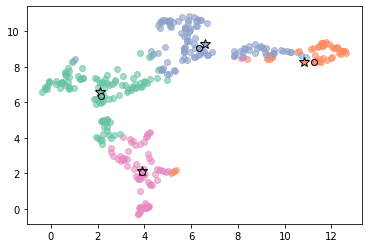

[Index(['2-02FERMA_t0'], dtype='object', name='ID'),
 Index(['2-14COEEN_t0'], dtype='object', name='ID'),
 Index(['nih_chp_02488_t1'], dtype='object', name='ID'),
 Index(['nih_chp_05625_t1'], dtype='object', name='ID')]

In [380]:
get_and_plot_closests_umap(best_pointnet_umap_embs)

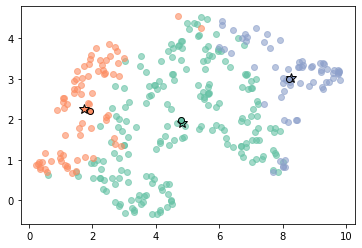

[Index(['sub-inhibition15_ses-pretraining_T1w'], dtype='object', name='ID'),
 Index(['nih_chp_05404_t1'], dtype='object', name='ID'),
 Index(['a0025_t1_s03'], dtype='object', name='ID')]

In [412]:
get_and_plot_closests_umap(best_densenet_umap_embs)

#### Good clustering

In [147]:
# corrected version of get_and_plot_closest_umap
# as the centroids are computed in the high dim space
def get_and_plot_closests(model_path, reducer, cmap='Set2'):
    model_embs = load_model_embs(model_path)
    model_preds = load_model_preds(model_path)

    # compute dimension reduction
    umap_embs = pd.DataFrame(reducer.transform(model_embs), index=model_embs.index)

    clusters = clustering(model_embs, 'AP', 5)
    umap_embs['true_cluster'] = clusters
    umap_embs['true_label'] = model_preds.label

    plt.figure()
    cmap = plt.get_cmap(cmap)

    closests = []
    i_clusters = np.sort(umap_embs.true_cluster.unique())

    for i in i_clusters:
        cluster = model_embs[umap_embs.true_cluster == i]

        # in the 4/30 dimension space
        centroid = get_centroid(cluster, None)
        closest = closest_to_centroid(cluster, centroid)
        closest = cluster.loc[closest.index,:]
        closests.append(closest.index)

        # plot in the 2 dimension space
        cluster_in_umap = umap_embs[umap_embs.true_cluster == i]
        plt.scatter(cluster_in_umap.loc[:,0], cluster_in_umap.loc[:,1],
                    color=cmap(i), alpha=0.6)

        centroid = reducer.transform(centroid.reshape(1,-1))[0]
        plt.plot(centroid[0], centroid[1], color=cmap(i),
                 marker='*', mec='black', ms=10)

        closest = reducer.transform(closest.values.reshape(1,-1))[0]
        plt.plot(closest[0], closest[1], color=cmap(i),
                 marker='o', mec='black')
        

    plt.show()

    return closests, umap_embs

In [148]:
def clusters_p_value(embs, verbose=True):
    if verbose:
        print("Overall proportion:", embs.true_label.mean())
        print()
        print("Clusters proportions:")
        print(embs.groupby('true_cluster').true_label.mean())
        print()
    
    cont = embs[['true_cluster', 'true_label']].pivot_table(index='true_cluster', columns='true_label', aggfunc=len).fillna(0).copy().astype(int)

    _, p_value, _, expected = chi2_contingency(cont)
    
    return {'cont': cont, 'p_value': p_value, 'expected': expected}

In [149]:
def clusters_repartition_bar_chart(embs):
    # compute the error bar size
    z = 1.96

    sdes = []
    n_clusters = len(embs.true_cluster.unique())
    for i in range(n_clusters):
        cluster = embs[embs.true_cluster == i]
        pop_prop = cluster.true_label.mean()
        sde = np.sqrt(pop_prop*(1-pop_prop)/cluster.shape[0])
        sdes.append(sde)
    
    # plot the bar chart
    cmap = plt.get_cmap('Set2')
    
    plt.bar(range(n_clusters), embs.groupby('true_cluster').true_label.mean(), color=[cmap(i) for i in range(n_clusters)],
            yerr=sdes)

    plt.hlines(embs.true_label.mean(), -0.5, n_clusters-0.5, color='r')

    plt.xticks(range(n_clusters))
    plt.ylabel("Paracingulate proportion")


#### Best pointnet

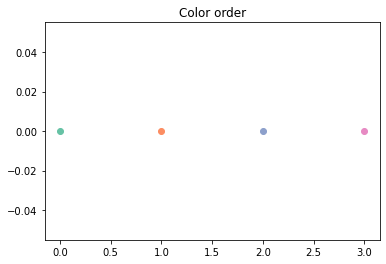

In [136]:
cmap = plt.get_cmap('Set2')

for i in range(4):
    plt.scatter([i], [0], color=cmap(i))

plt.title("Color order")
plt.show()

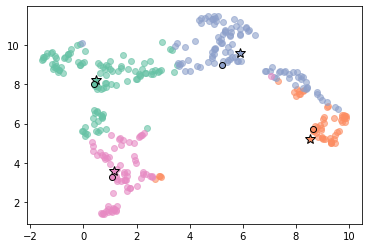

[Index(['a0008_t1_s03'], dtype='object', name='ID'),
 Index(['nih_chp_01052_t1'], dtype='object', name='ID'),
 Index(['2-04HEBTO_t0'], dtype='object', name='ID'),
 Index(['nih_chp_05132_t1'], dtype='object', name='ID')]

In [57]:
closests, umap_embs_best_pointnet = get_and_plot_closests(best_pointnet, best_pointnet_reducer)
closests

In [69]:
# print centroids
umap_embs_best_pointnet.true_label[['a0008_t1_s03', 'nih_chp_01052_t1', '2-04HEBTO_t0', 'nih_chp_05132_t1']]

ID
a0008_t1_s03        0
nih_chp_01052_t1    0
2-04HEBTO_t0        1
nih_chp_05132_t1    0
Name: true_label, dtype: int64

In [80]:
clusters_p_value(umap_embs_best_pointnet)

Overall proportion: 0.4222873900293255

Clusters proportions:
true_cluster
0    0.342342
1    0.528302
2    0.561905
3    0.263889
Name: true_label, dtype: float64



{'cont': true_label     0   1
 true_cluster        
 0             73  38
 1             25  28
 2             46  59
 3             53  19,
 'p_value': 9.826198784207433e-05,
 'expected': array([[64.12609971, 46.87390029],
        [30.61876833, 22.38123167],
        [60.65982405, 44.34017595],
        [41.59530792, 30.40469208]])}

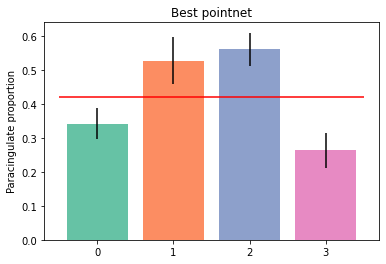

In [133]:
clusters_repartition_bar_chart(umap_embs_best_pointnet)
plt.title("Best pointnet")
#plt.legend(["Overall paracingulate proportion"])
ymin, ymax = plt.gca().get_ylim()
plt.show()

In [121]:
print(ymin, ymax)

0.0 0.6408405537416924


#### Best Densenet

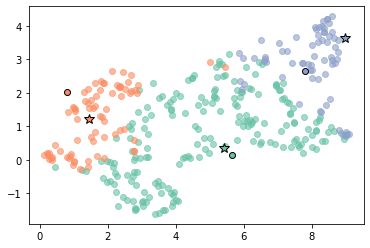

[Index(['nih_chp_04118_t1'], dtype='object', name='ID'),
 Index(['nih_chp_03329_t1'], dtype='object', name='ID'),
 Index(['nih_chp_01134_t1'], dtype='object', name='ID')]

In [46]:
closests, umap_embs_best_densenet = get_and_plot_closests(best_densenet, best_densenet_reducer)
closests

In [47]:
umap_embs_best_densenet.true_label[['nih_chp_04118_t1', 'nih_chp_03329_t1', 'nih_chp_01134_t1']]

ID
nih_chp_04118_t1    1
nih_chp_03329_t1    0
nih_chp_01134_t1    0
Name: true_label, dtype: int64

In [81]:
clusters_p_value(umap_embs_best_densenet)

Overall proportion: 0.4222873900293255

Clusters proportions:
true_cluster
0    0.492462
1    0.213333
2    0.447761
Name: true_label, dtype: float64



{'cont': true_label      0   1
 true_cluster         
 0             101  98
 1              59  16
 2              37  30,
 'p_value': 0.000149385311737358,
 'expected': array([[114.96480938,  84.03519062],
        [ 43.32844575,  31.67155425],
        [ 38.70674487,  28.29325513]])}

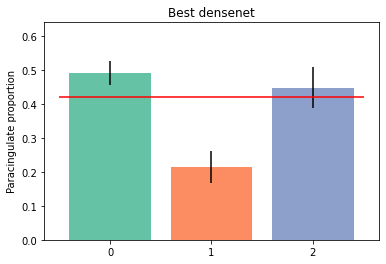

In [134]:
ax = plt.gca()
ax.set_ylim(ymin, ymax)
clusters_repartition_bar_chart(umap_embs_best_densenet)
plt.title("Best densenet")
#plt.legend(["Overall paracingulate proportion"])
plt.show()

#### Best convnet

In [150]:
closests, umap_embs_best_convnet = get_and_plot_closests(best_convnet, best_convnet_reducer)
closests

In [ ]:
umap_embs_best_convnet.true_label[['nih_chp_04118_t1', 'nih_chp_03329_t1', 'nih_chp_01134_t1']]

In [ ]:
clusters_p_value(umap_embs_best_convnet)

In [ ]:
ax = plt.gca()
ax.set_ylim(ymin, ymax)
clusters_repartition_bar_chart(umap_embs_best_convnet)
plt.title("Best convnet")
#plt.legend(["Overall paracingulate proportion"])
plt.show()

## Clustering methods comparison

In [283]:
def compare_clustering_methods(model_path, methods=['kmeans', 'AP'],
    Ns=range(2,11), verbose=False):

    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)
    if verbose:
        print("Data df:")
        print(data_df[:5])
    
    ## apply umap
    reducer = umap.UMAP()
    umap_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(umap_embs.shape)
        print(umap_embs[:5])


    ## loop over the clustering methods and parameters
    for method in methods:
        for n_clusters in Ns:
            print(method, n_clusters)

            clusters = clustering(data_df, method, n_clusters)
            
            silh_score = silhouette_score(data_df, clusters)
            print(silh_score)

            plt.figure()
            plt.scatter(umap_embs[:,0], umap_embs[:,1], c=clusters, alpha=0.6)
            plt.title(f"{method}, n = {n_clusters}, " + "silhouette score = {:.2f}".format(silh_score))
            plt.show()

    # for each model x condition do
    #   do the clustering
    #   compute the centroid
    #   get the closest to centroids
    #   compute silhouette score
    #   plot the clusters 

kmeans 2
0.3214952517798337


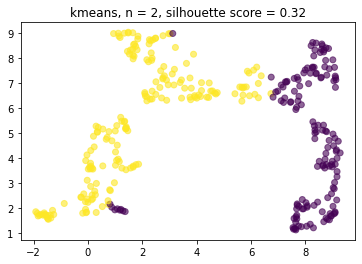

kmeans 3
0.367226835958536


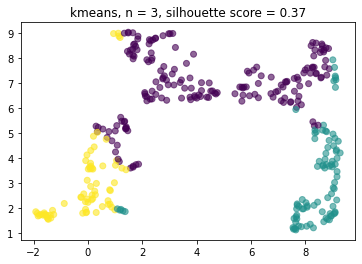

kmeans 4
0.3932691895580512


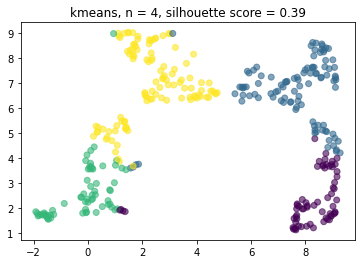

kmeans 5
0.37260525021961816


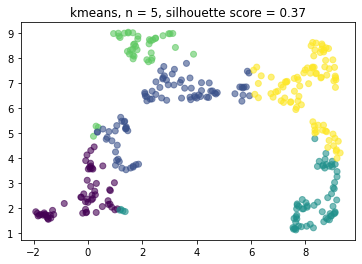

kmeans 6
0.3661130491446001


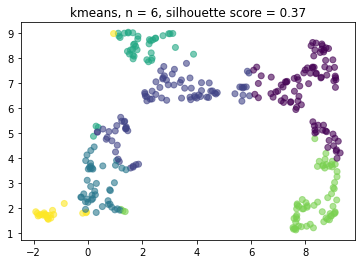

kmeans 7
0.34403285556822283


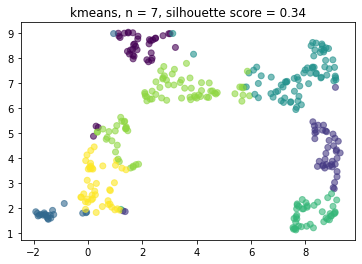

kmeans 8
0.34969308987007625


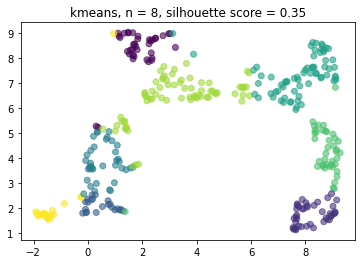

kmeans 9
0.3325693267777941


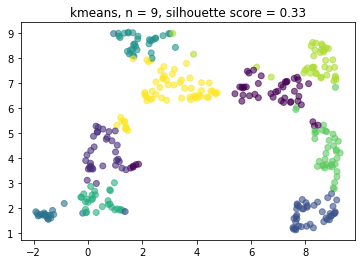

kmeans 10
0.3308479149708199


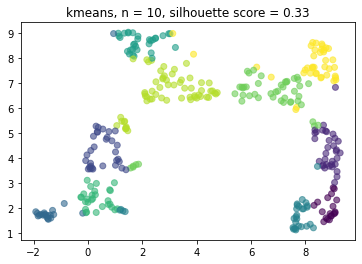

AP 2
0.2882057340948437


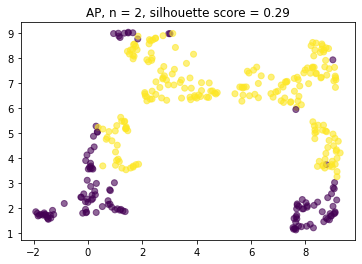

AP 3
0.2882057340948437


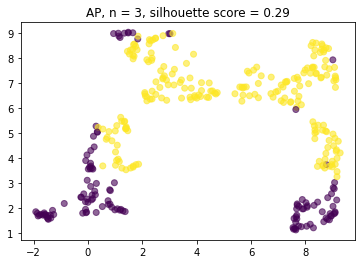

AP 4
0.3818141966006937


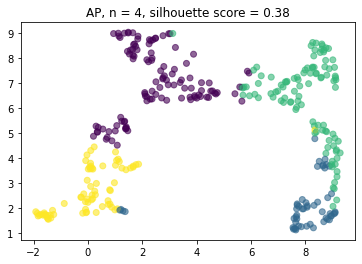

AP 5
0.3818141966006937


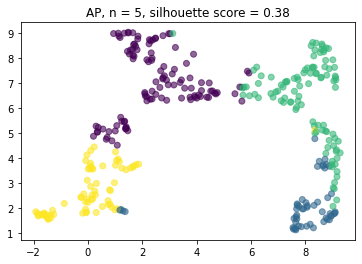

AP 6
0.3818141966006937


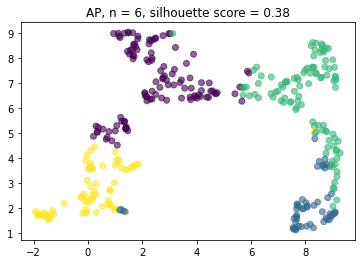

AP 7
0.3818141966006937


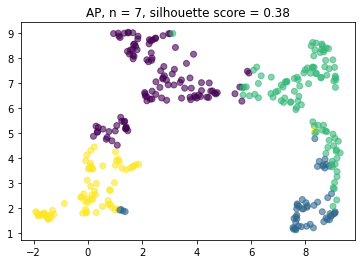

AP 8
0.3818141966006937


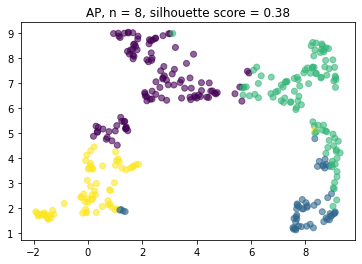

AP 9
0.3818141966006937


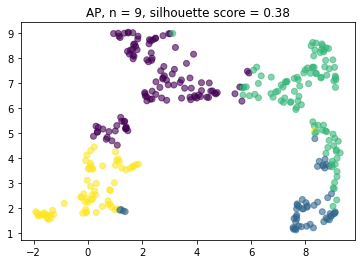

AP 10
0.3818141966006937


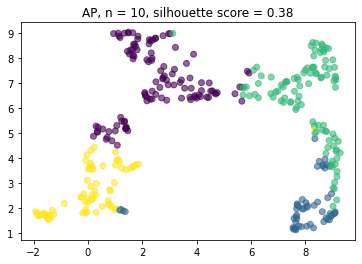

In [289]:
compare_clustering_methods(best_pointnet, Ns=range(2,11))

kmeans 2
0.31244243051826026


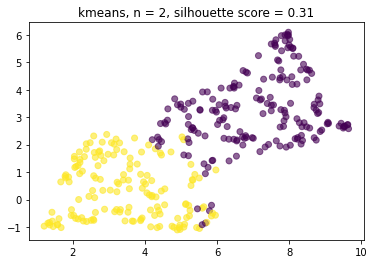

kmeans 3
0.21458722308481426


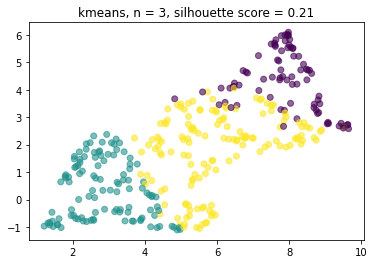

kmeans 4
0.20042356179858412


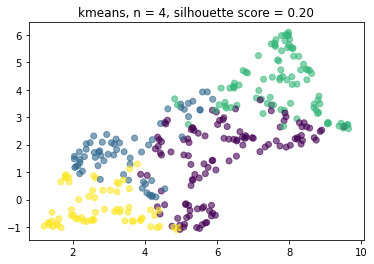

kmeans 5
0.1898202027643374


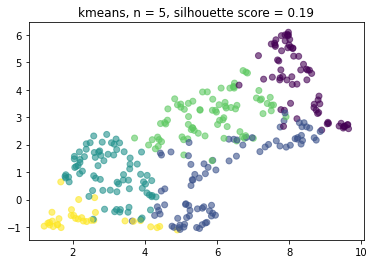

kmeans 6
0.20088984748685643


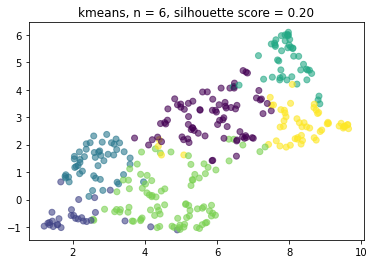

kmeans 7
0.1962055238885443


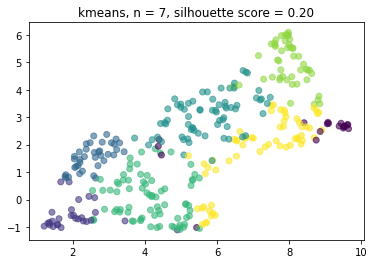

kmeans 8
0.19355019686657543


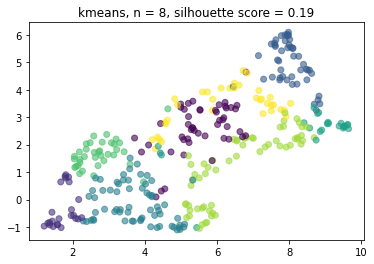

kmeans 9
0.17409155475702956


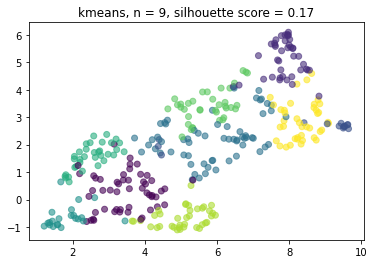

kmeans 10
0.17477416103489957


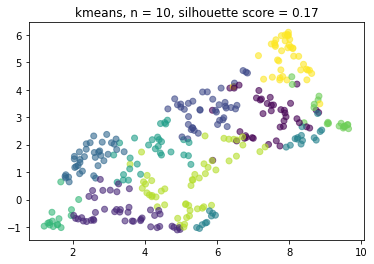

AP 2
0.2267038740636274


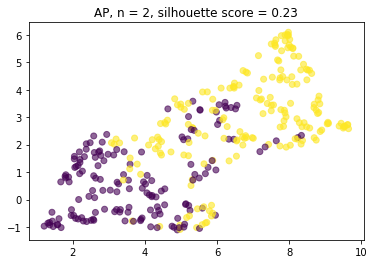

AP 3
0.19144104457942768


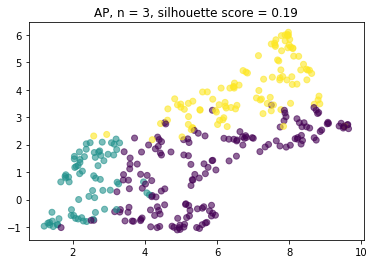

AP 4
0.20376198772299442


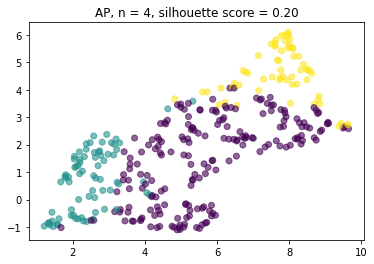

AP 5
0.20376198772299442


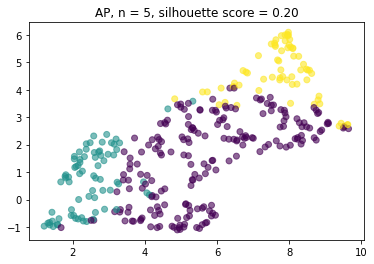

AP 6
0.15331198075521435


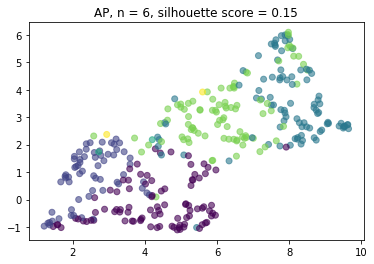

AP 7
0.15331198075521435


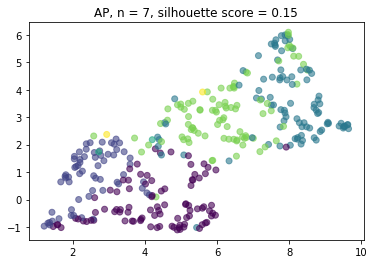

AP 8
0.15331198075521435


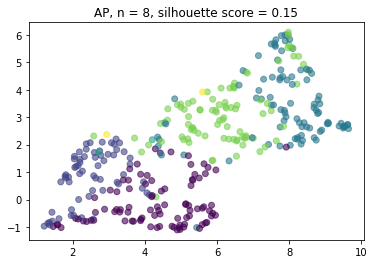

AP 9
0.15331198075521435


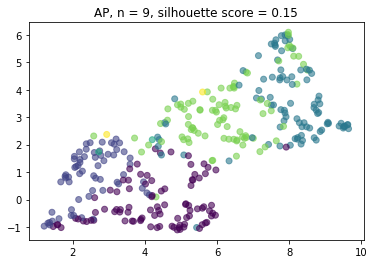

AP 10
0.15331198075521435


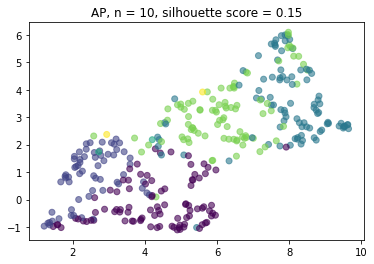

In [292]:
compare_clustering_methods(best_densenet)